# Seguimiento de objetos por videomicroscopía
VI EIIMFE

El seguimiento de objetos es una herramienta de visión por computadora que identifica y sigue objetos en movimiento a lo largo de una secuencia de cuadros de video.

### Las etapas clave son

   1. Detección de objetos en el cuadro inicial
   1. Segmentación y asignación de una etiqueta única a cada objeto para su identificación
   1. Seguimiento de los objetos detectados a lo largo del tiempo
   1. Actualización de las posiciones de los objetos
   1. Registro de las trayectorias de cada partícula
 
 Posteriormente se realiza el análisis de las trayectorias de acuerdo a la necesidad experimental

El seguimiento de objetos se puede hacer de manera única o siguiendo múltiples objetos al mismo tiempo. De esto dependerá el tipo de algoritmos usados para su detección y seguimiento.

### Aplicaciones de detección de objetos

<img src="Imagenes/Applications-of-Object-Detection-in-real-life_W640.jpg" style="width: 400px;"/>

### Detección de objetos en video microscopía

<table>
    <tr>
        <th style="text-align: center;">
            <h2>Sistema experimental</h2>
        </th>
        <th colspan=2 style="text-align: center;">
            <h2>Ejemplo</h2>
        </th>
    </tr>
    <tr>
        <td style="text-align: center;">
            <h3>Vesículas gigantes de una bicapa</h3>
        </td>
        <td colspan=2>
            <img src="Imagenes/GUVs_tracking.png" alt="GUVs tracking" width="500" height="600"/>
        </td>
    </tr>
    <tr> 
        <td style="text-align: center;">
           <h3>Células</h3>
        </td>
        <td>
            <img src="Imagenes/T00079.jpg" alt="Células" width="500" height="600"/>
        </td>
        <td>
            <img src="Imagenes/Cells_masked.png" alt="Mask" width="500" height="600"/>
        </td>
    </tr>
    <tr>
        <td style="text-align: center;">
            <h3>Partículas fluorescentes</h3>
        </td>
        <td colspan=2>
            <img src="Imagenes/Particulas.jpg" alt="Partículas fluorescentes" width="500" height="600"/>
        </td>
    </tr>
</table>

## Ejemplo: Detección de GUVs

Importar las librerías necesarias

In [56]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops,regionprops_table
import math

Leer el archivo de video y seleccionar un cuadro 

<div class="alert alert-block alert-warning">
    <b>Nota</b> Descarga los <a href="https://uaslpedu-my.sharepoint.com/:f:/g/personal/alejandro_moreno_uaslp_mx/EpDFliy5rzRFqsGggvZuj7UBK_OAkTIUKzn3xrqj0ji-CA?e=3BZRgC">videos</a> a una nueva carpeta llamada Videos, en el directorio de trabajo para el taller.
</div>

In [2]:
video_name = "Videos/Guvs.mp4"
frame_no = 500
cap = cv2.VideoCapture(video_name)
cap.set(1,frame_no)
ret, frame = cap.read()

Procesar el cuadro seleccionado

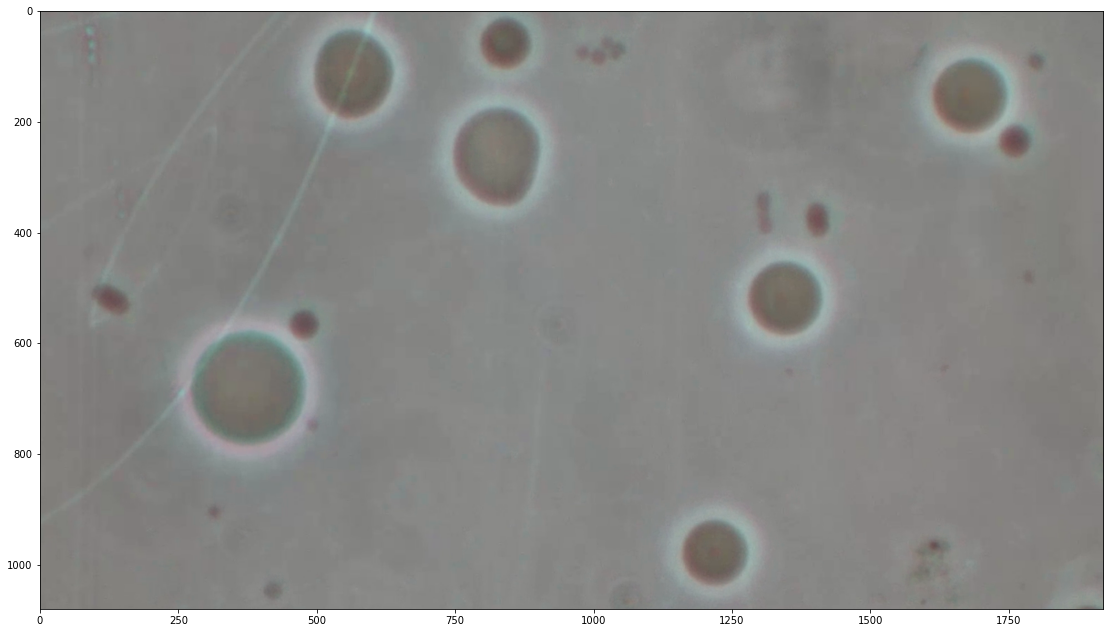

In [3]:
plt.figure(figsize = (20,11))
plt.imshow(frame);

Convertir en escala de grises

In [49]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

Suavizar la imagen pasando un filtro bilateral. Reduce el ruido en la imagen preservando los bordes lo que permite una mejor segmentación de los objetos.
Documentación de la función de filtro bilateral: [cv2.bilateralFilter()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed)

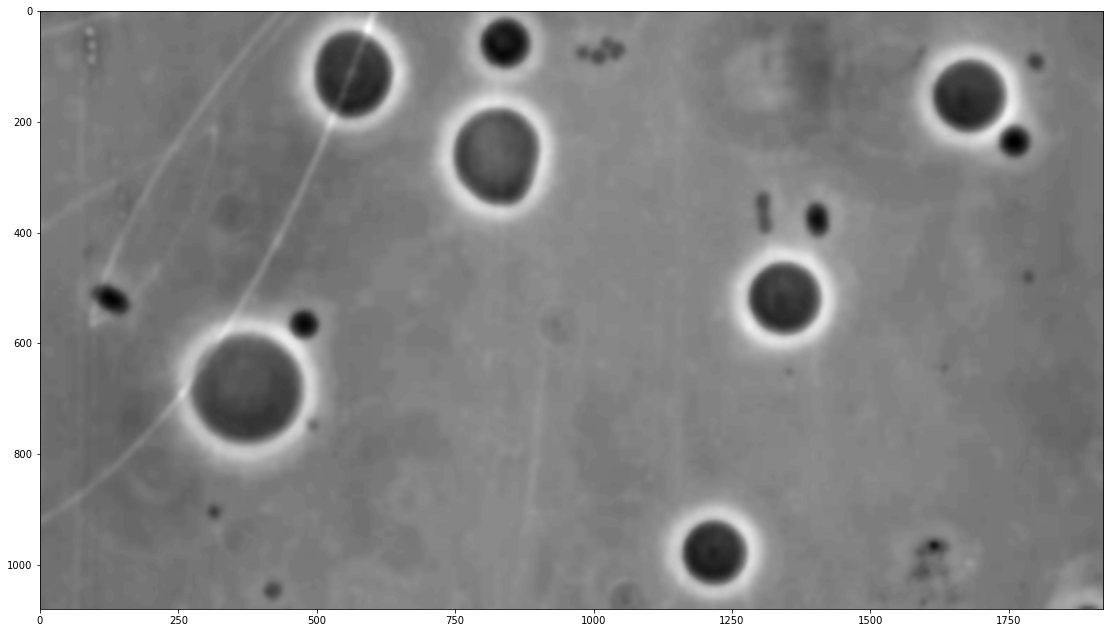

In [50]:
filter_frame = cv2.bilateralFilter(gray_frame,15,30,100)
plt.figure(figsize = (20,11))
plt.imshow(filter_frame, cmap='gray');

Calcular valores promedio de intensidad

In [51]:
mean = filter_frame.mean()
var = filter_frame.var()
print(f'valor medio de intensidad: {mean:.2f}, variación estándar: {np.sqrt(var):.2f}')
print(f'Mínimo: {filter_frame.min()}, Máximo: {filter_frame.max()}')

valor medio de intensidad: 132.61, variación estándar: 9.41
Mínimo: 84, Máximo: 182


Binarizar la imágen para su posterior análisis

**Caso 1**

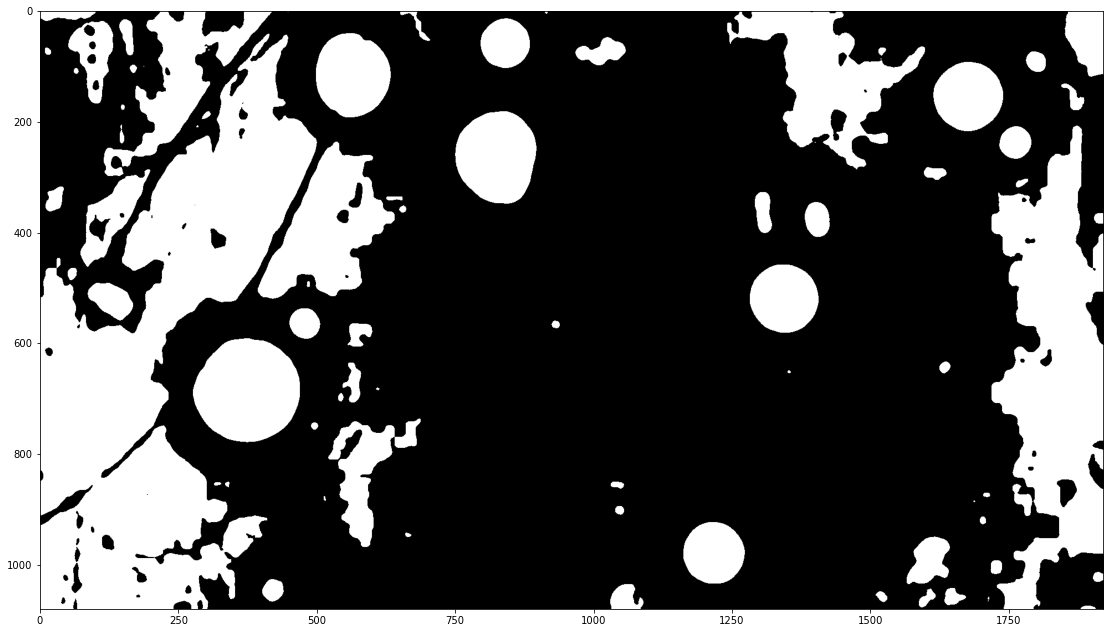

In [79]:
ret, simple_thresh = cv2.threshold(filter_frame, mean*0.98, 255, cv2.THRESH_BINARY_INV) 
plt.figure(lfigsize = (20,11))
plt.imshow(otsu_thresh, cmap='gray');

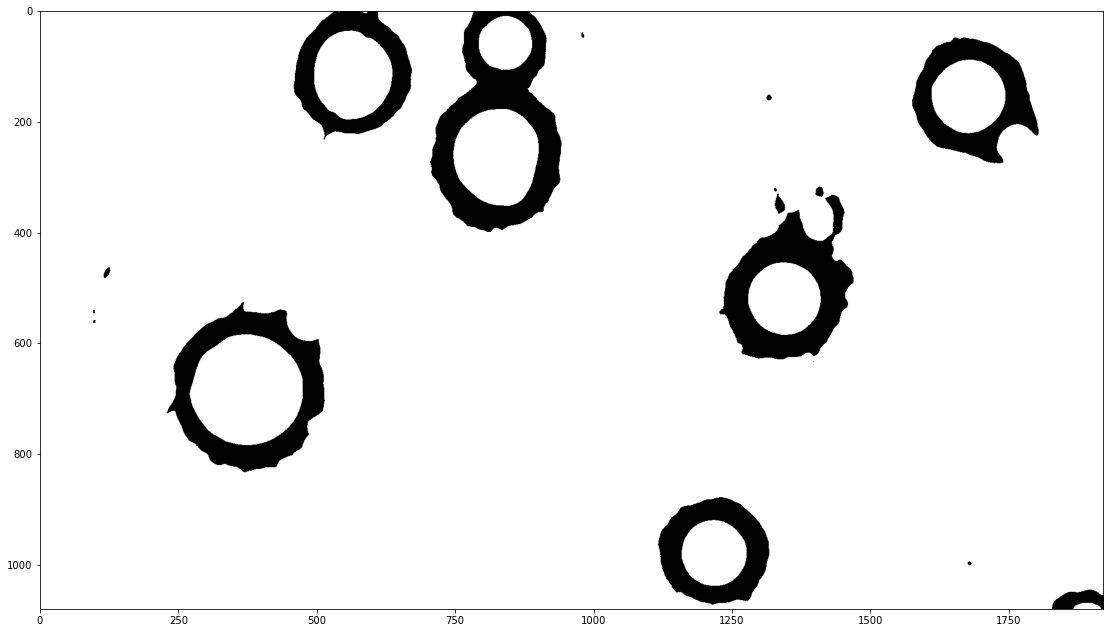

In [80]:
ret, otsu_thresh = cv2.threshold(filter_frame, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 
plt.figure(figsize = (20,11))
plt.imshow(otsu_thresh, cmap='gray');

Etiquetar los objetos

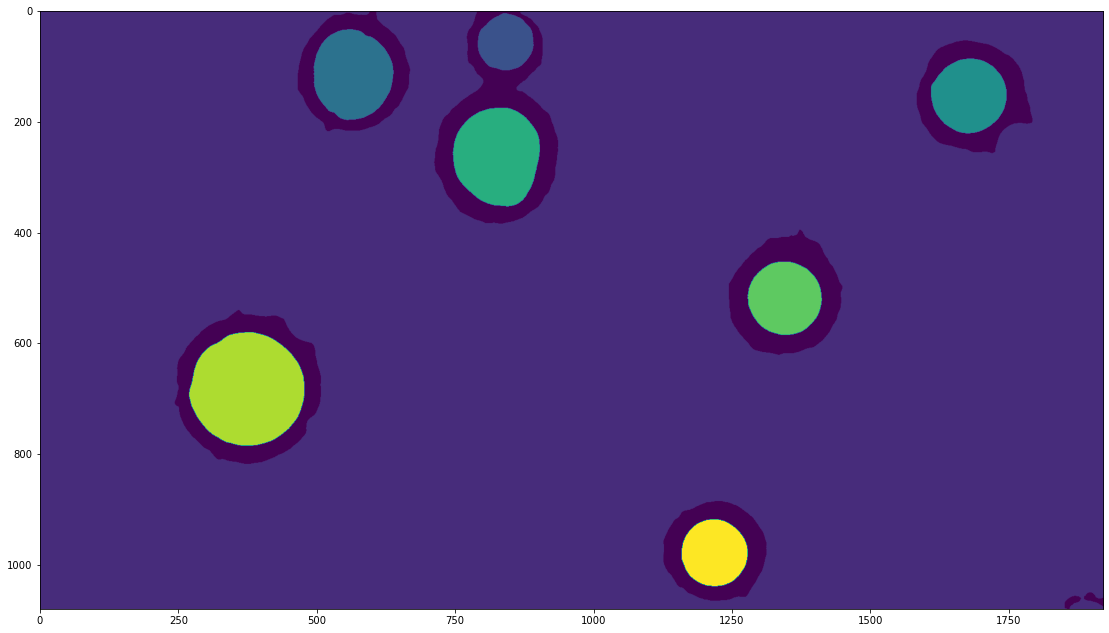

In [44]:
l_img = label(otsu_thresh)
plt.figure(figsize = (20,11))
plt.imshow(l_img);

Identificar cada una de los objetos con sus propiedades

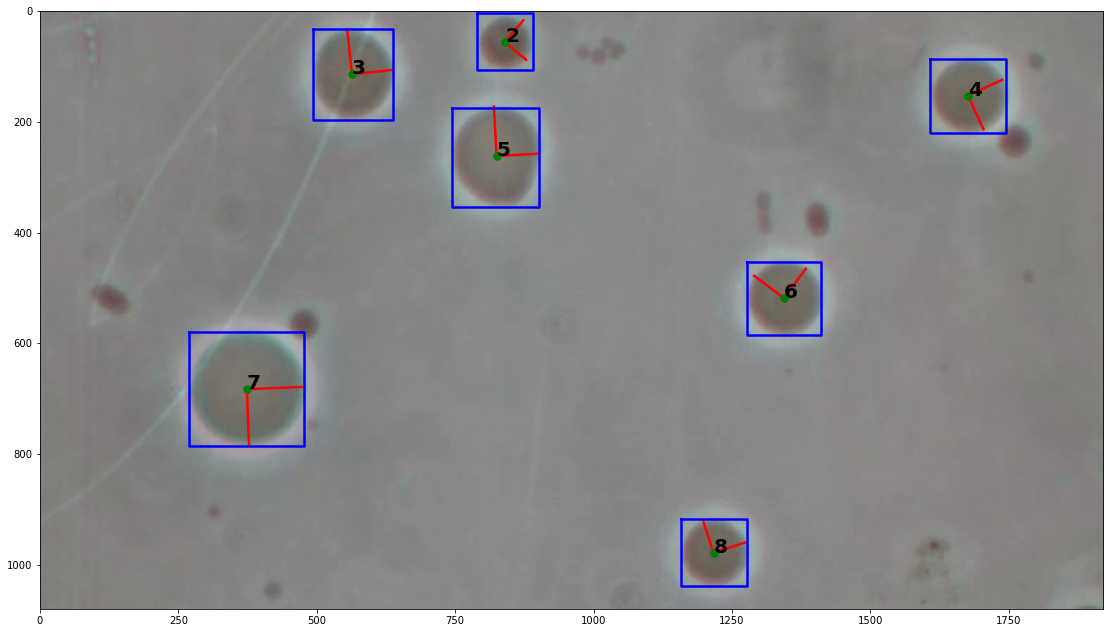

In [66]:
regions = regionprops(l_img)
fig, ax = plt.subplots(figsize=(20,11))
ax.imshow(frame, cmap=plt.cm.gray)

for props in regions[1:]:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)
    ax.text(x0,y0,props.label,weight=1000, size=20)
    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

#ax.axis((0, 2048, 1600, 0))
plt.show()

Medir las propiedades geométricas de cada objeto, como su centroide, longitud de ejes, área, etc.

In [53]:
props = regionprops_table(
    l_img,
    properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length','area','eccentricity','bbox','label','perimeter')
)
pd.DataFrame(props)

,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length,area,eccentricity,bbox-0,bbox-1,bbox-2,bbox-3,label,perimeter
0,554.217436,965.134076,1.566213,2263.859540,1240.569208,1833683,0.836486,0,0,1080,1920,1,10775.767132
1,56.281105,840.003751,-0.693616,102.810186,99.130451,7997,0.265145,4,790,107,891,2,333.948268
2,114.060825,563.505891,0.106510,162.163677,143.496736,18249,0.465803,33,494,197,638,3,509.872150
3,152.510010,1676.141407,-1.141012,135.841838,133.029187,14186,0.202440,86,1608,221,1744,4,443.102597
4,261.609737,824.663533,0.053372,178.993749,156.448659,21916,0.485844,175,745,353,902,5,556.114790
5,518.213072,1343.668426,0.929812,133.740392,131.684541,13831,0.174664,453,1277,585,1411,6,438.617316
6,682.813197,373.655941,-1.531249,206.528737,204.117725,33099,0.152354,580,269,785,477,7,680.482323
7,978.234608,1216.531137,0.313731,121.264011,118.886532,11321,0.197046,918,1158,1039,1277,8,395.161472


<div class="alert alert-block alert-info">
    <b>Nota</b> Revisar contenido del la rutina <em>ParticleTracker.py</em>. Ejecutarlo para medir la trayectoria de partículas coloidales en suspensión
</div>

## Ejercicio
### Detección de partículas fluorescentes
Utiliza las mismas herramientas antes descritas para detectar las partículas 

Leer el archivo de video y seleccionar un cuadro 

Procesar el cuadro seleccionado

Convertir en escala de grises

Suavizar la imagen pasando un filtro bilateral. Reduce el ruido en la imagen preservando los bordes lo que permite una mejor segmentación de los objetos.
Documentación de la función de filtro bilateral: [cv2.bilateralFilter()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed)

Binarizar la imágen para su posterior análisis

Etiquetar los objetos

Identificar cada una de los objetos con sus propiedades